In [1]:
from keras.models import Sequential
from keras import optimizers
from keras import models
from keras import layers
from keras.layers import BatchNormalization
from keras.layers import Dropout
import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sns
import pywt
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
import joblib
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [3]:
group = 'Oh'
J = '4'
dir = '../ml_cr/TrainingData_{}_{}/'.format(group, J)
data = dir + 'generated_data_{}.csv'
targets = dir + 'generated_targets_{}.csv'
x = np.array(pd.read_csv(data.format(50000), header=None))
y = np.array(pd.read_csv(targets.format(50000), header=None))

In [4]:
channels = len(x[0])//64
x = np.reshape(x, (-1, 64, channels))
x.shape

(50000, 64, 5)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

x_val = x_test[:2000]
x_test = x_test[2000:]
y_val = y_test[:2000]
y_test = y_test[2000:]

In [13]:
# center the image data for each channel (mean of zero)
x_mean = np.mean(x_train, axis=(0,1), keepdims=True)
x_train -= x_mean
x_val -= x_mean
x_test -= x_mean

In [5]:
x_mean = np.load(dir + 'x_mean_{}_{}_1D.npy'.format(group, J))

In [7]:
# normalize each of the targets (mean of zero and std of one)
# y_mean = np.mean(y_train, axis=(0,), keepdims=True)
# y_train -= y_mean
# y_val -= y_mean
# y_test -= y_mean
# y_std = np.std(y_train, axis=(0,), keepdims=True)
# y_train /= y_std
# y_val /= y_std
# y_test /= y_std

In [6]:
model = Sequential()

model.add(layers.Conv1D(128, 10, activation='relu', input_shape=(64, 6)))
model.add(layers.Conv1D(256, 10, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(2))

model.add(layers.Conv1D(384, 10, activation='relu'))
model.add(layers.Conv1D(256, 10, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.GlobalAveragePooling1D())

model.add(layers.Dense(2048, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(4096, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(2))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 55, 128)           7808      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 256)           327936    
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 256)           1024      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 14, 384)           983424    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 5, 256)            983296    
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 256)           

In [7]:
from keras.models import load_model
model = load_model(dir + '{}_{}_1D_model.h5'.format(group, J))

Train on 40000 samples, validate on 2000 samples
Epoch 1/45
40000/40000 [==============================] - 17s 434us/step - loss: 300.7454 - mae: 12.2370 - val_loss: 96.7642 - val_mae: 5.6622
Epoch 2/45
40000/40000 [==============================] - 12s 305us/step - loss: 90.1976 - mae: 6.2751 - val_loss: 119.7552 - val_mae: 6.5496
Epoch 3/45
40000/40000 [==============================] - 13s 316us/step - loss: 9.9957 - mae: 1.9297 - val_loss: 209.6994 - val_mae: 8.0904
Epoch 4/45
40000/40000 [==============================] - 13s 324us/step - loss: 8.7556 - mae: 1.7756 - val_loss: 127.4016 - val_mae: 6.5446
Epoch 5/45
40000/40000 [==============================] - 13s 333us/step - loss: 7.5595 - mae: 1.6295 - val_loss: 111.5683 - val_mae: 5.2207
Epoch 6/45
40000/40000 [==============================] - 13s 336us/step - loss: 7.0545 - mae: 1.5647 - val_loss: 67.7676 - val_mae: 5.0164
Epoch 7/45
40000/40000 [==============================] - 15s 367us/step - loss: 6.6255 - mae: 1.5216 -

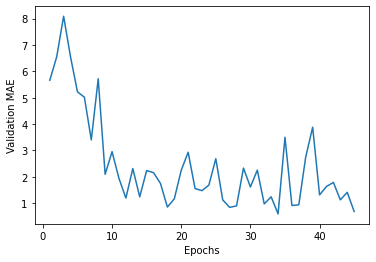

In [11]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(x_train,
    y_train,
    epochs=45,
    batch_size=512,
    validation_data=(x_val, y_val))

average_mae_history = history.history['val_mae']
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [12]:
model.evaluate(x_test, y_test)

8000/8000 [==============================] - 2s 278us/step


[1.3571205213069917, 0.6934912204742432]

In [8]:
y_real = np.array(pd.read_csv(targets.format(1000), header=None))
example_x = np.array(pd.read_csv(data.format(1000), header=None))

In [9]:
from sklearn import metrics
example_x = np.reshape(example_x, (-1, 64, channels))
example_x -= x_mean
y_pred = model.predict(example_x)
# y_pred = (y_pred * y_std) + y_mean

In [10]:
print('Mean absolute error: {}'.format(metrics.mean_absolute_error(y_real[:,0], y_pred[:,0])))
print('Mean squared error: {}'.format(metrics.mean_squared_error(y_real[:,0], y_pred[:,0])))
print('Explained varience score: {}'.format(metrics.explained_variance_score(y_real[:,0], y_pred[:,0])))
print('r^2 score: {}'.format(metrics.r2_score(y_real[:,0], y_pred[:,0])))

Mean absolute error: 0.5857021031909985
Mean squared error: 0.6439075696066198
Explained varience score: 0.9968091461018397
r^2 score: 0.9967713127233434


In [11]:
print('Mean absolute error: {}'.format(metrics.mean_absolute_error(y_real[:,1], y_pred[:,1])))
print('Mean squared error: {}'.format(metrics.mean_squared_error(y_real[:,1], y_pred[:,1])))
print('Explained varience score: {}'.format(metrics.explained_variance_score(y_real[:,1], y_pred[:,1])))
print('r^2 score: {}'.format(metrics.r2_score(y_real[:,1], y_pred[:,1])))

Mean absolute error: 0.08712309453313219
Mean squared error: 0.010976948103274231
Explained varience score: 0.9821812539475554
r^2 score: 0.9657014182220169


Text(0.5, 0, 'Absolute error')

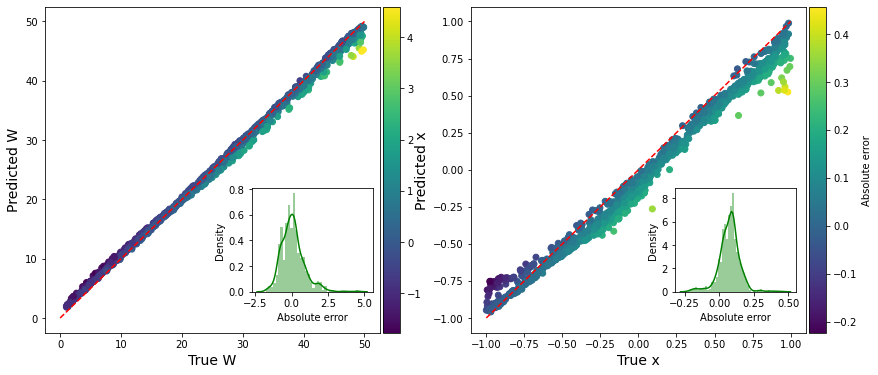

In [12]:
data = pd.DataFrame()

data['pred1'] = np.array(y_pred[:,0])
data['real1'] = pd.DataFrame(y_real).reset_index(drop=True)[0]
data['error1'] = data['pred1']- data['real1']

data2 = pd.DataFrame()
data2['pred2'] = np.array(y_pred[:,1])
data2['real2'] = pd.DataFrame(y_real).reset_index(drop=True)[1]
data2['error2'] = data2['pred2']- data2['real2']

def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14,6))
ax2 = plt.axes([0.33, 0.22, 0.12, 0.24])
ax3 = plt.axes([0.75, 0.22, 0.12, 0.24])
# fig.subplots_adjust(left=0.2, bottom=None, right=None, top=None, wspace=None, hspace=None)
error0 = y_real[:,0]-y_pred[:,0]
error1 = y_real[:,1]-y_pred[:,1]
# df['Target'] = df['Target'].astype('category')

p1 = ax[0].scatter(y_real[:,0], y_pred[:,0], c=error0)
cb = colorbar(p1)
# cb.ax.set_ylabel('Absolute error')

ax[0].set_xlabel('True W', fontsize=14)
ax[0].set_ylabel('Predicted W', fontsize=14)
# legend1 = ax[0].legend(*p1.legend_elements(num=5), loc='upper left', title='Absolute error')
ax[0].plot([0, 50], [0, 50], c='r', ls='--')


p2 = ax[1].scatter(y_real[:,1], y_pred[:,1], c=error1)
cb2 = colorbar(p2)
cb2.ax.set_ylabel('Absolute error')
# legend2 = ax[1].legend(*p2.legend_elements(num=6), loc='upper left', title='Absolute error')
ax[1].set_xlabel('True x', fontsize=14)
ax[1].set_ylabel('Predicted x', fontsize=14)
ax[1].set_ylim(-1.1, 1.1)
ax[1].plot([-1, 1], [-1, 1], c='r', ls='--')


sns.distplot(error0, color="g", kde=True, ax=ax2, norm_hist=True)
ax2.set_xlabel('Absolute error')
ax2.set_ylabel('Density')
sns.distplot(error1, color="g", kde=True, ax=ax3, norm_hist=False)
ax3.set_ylabel('Density')
ax3.set_xlabel('Absolute error')

In [14]:
def add_inner_title(ax, title, loc, size=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    from matplotlib.patheffects import withStroke
    if size is None:
        size = dict(size=plt.rcParams['legend.fontsize'])
    at = AnchoredText(title, loc=loc, prop=size,
                      pad=0., borderpad=0.5,
                      frameon=False, **kwargs)
    ax.add_artist(at)
    at.txt._text.set_path_effects([withStroke(foreground="w", linewidth=3)])
    return at

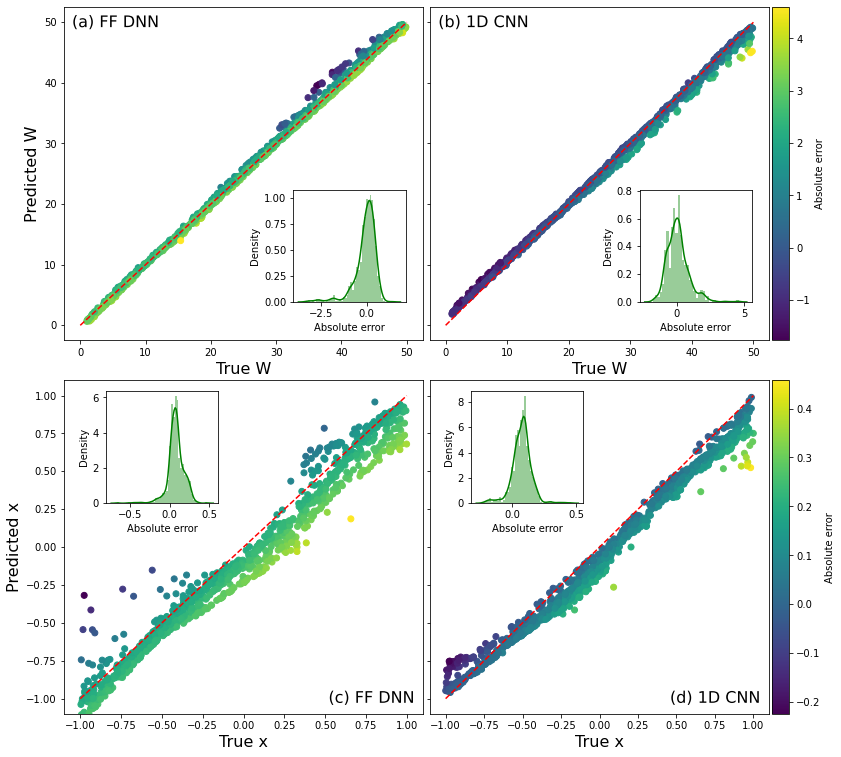

In [17]:
ffdata = pd.read_csv('ffdata.csv', header=None)
zs = np.concatenate([ffdata[2], data['error1']], axis=0)
min_, max_ = zs.min(), zs.max()
ffdata2 = pd.read_csv('ffdata2.csv', header=None)
zs2 = np.concatenate([ffdata2[2], data2['error2']], axis=0)
min2_, max2_ = zs2.min(), zs2.max()

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(13,13))
plt.subplots_adjust(wspace=0.02, hspace=0.12)

ax2 = plt.axes([0.37, 0.565, 0.12, 0.12])
ax3 = plt.axes([0.74, 0.565, 0.12, 0.12])
ax22 = plt.axes([0.17, 0.35, 0.12, 0.12])
ax32 = plt.axes([0.56, 0.35, 0.12, 0.12])

error0 = ffdata[1]-ffdata[0]
error1 = y_real[:,0]-y_pred[:,0]
error02 = ffdata2[1]-ffdata2[0]
error12 = y_real[:,1]-y_pred[:,1]

norm = plt.Normalize(min_, max_)
norm2 = plt.Normalize(min2_, max2_)

p1 = ax[0,0].scatter(ffdata[1], ffdata[0], c=error0)
p2 = ax[0,1].scatter(y_real[:,0], y_pred[:,0], c=error1)
p12 = ax[1,0].scatter(ffdata2[1], ffdata2[0], c=error02)
p22 = ax[1,1].scatter(y_real[:,1], y_pred[:,1], c=error12)

ax[0,0].plot([0, 50], [0, 50], c='r', ls='--')
ax[0,1].plot([0, 50], [0, 50], c='r', ls='--')
ax[1,0].set_ylim(-1.1, 1.1)
ax[1,0].plot([-1, 1], [-1, 1], c='r', ls='--')
ax[1,1].set_ylim(-1.1, 1.1)
ax[1,1].plot([-1, 1], [-1, 1], c='r', ls='--')

cb = colorbar(p2)
cb.ax.set_ylabel('Absolute error')
cb2 = colorbar(p22)
cb2.ax.set_ylabel('Absolute error')

ax[0,1].tick_params(labelleft=False)  
ax[1,1].tick_params(labelleft=False)  

sns.distplot(error0, color="g", kde=True, ax=ax2, norm_hist=True)
ax2.set_xlabel('Absolute error')
ax2.set_ylabel('Density')
sns.distplot(error1, color="g", kde=True, ax=ax3, norm_hist=False)
ax3.set_ylabel('Density')
ax3.set_xlabel('Absolute error')

sns.distplot(error02, color="g", kde=True, ax=ax22, norm_hist=True)
ax22.set_xlabel('Absolute error')
ax22.set_ylabel('Density')
sns.distplot(error12, color="g", kde=True, ax=ax32, norm_hist=False)
ax32.set_ylabel('Density')
ax32.set_xlabel('Absolute error')

ax2.patch.set_alpha(0.5)
ax3.patch.set_alpha(0.5)
ax22.patch.set_alpha(0.5)
ax32.patch.set_alpha(0.5)

ax[0,0].set_xlabel('True W', fontsize=16)
ax[0,0].set_ylabel('Predicted W', fontsize=16)
ax[0,1].set_xlabel('True W', fontsize=16)
ax[1,0].set_xlabel('True x', fontsize=16)
ax[1,0].set_ylabel('Predicted x', fontsize=16)
ax[1,1].set_xlabel('True x', fontsize=16)

add_inner_title(ax[0,0], '(a) FF DNN', loc=2, size=dict(size=16))
add_inner_title(ax[0,1], '(b) 1D CNN', loc=2, size=dict(size=16))
add_inner_title(ax[1,0], '(c) FF DNN', loc=4, size=dict(size=16))
add_inner_title(ax[1,1], '(d) 1D CNN', loc=4, size=dict(size=16))


plt.show()